# Part 1 Sequence Tagging: NER


## Q1.1 Word Embedding


### Q1.1.1 Download Dependency


In [1]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


### Q1.1.2 Download the pretrained word2vec embeddings


In [1]:
import gensim.downloader
import numpy as np
import pandas as pd
import tqdm
import time
# Download the embeddings "word2vec-google-news-300"
w2v = gensim.downloader.load('word2vec-google-news-300')

# Part 2 Sentence-Level Categorization: Question Classification


## Let us first pre-process the dataset, and create a development set


In [2]:
random_seed = 42

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Define the file paths
train_file = "data/Part 2/train.csv"
test_file = "data/Part 2/test.csv"

# Load the original training data
original_train_df = pd.read_csv(train_file)

# Split the original training data into train and validation sets
train_df, validation_df = train_test_split(original_train_df, test_size=500, random_state=random_seed)

# Load the test data
test_df = pd.read_csv(test_file)

In [4]:
print("Original shape:   ", original_train_df.shape)
print("Training shape:   ", train_df.shape)
print("Validation shape: ", validation_df.shape)
print("Test shape:\t  ", test_df.shape)

Original shape:    (5452, 3)
Training shape:    (4952, 3)
Validation shape:  (500, 3)
Test shape:	   (500, 3)


### Now let us randomly select 4 class from the 6 different coarse labels and combine the remaing labels to form a single class 'OTHERS'


In [5]:
# Column name   	 Description
# label-coarse  	 The coarse-grained label for the question. (String)
# label-fine    	 The fine-grained label for the question. (String)
# text          	 The text of the question. (String)
# We will be focusing on the label-coarse, to use RNNs approach for classification of question labels.
train_df

,label-coarse,label-fine,text
4943,2,34,What is Mikhail Gorbachev 's middle initial ?
2346,0,0,How does the tail affect the flight of a kite ?
1835,5,21,What were the first three cities to have a pop...
4047,1,1,What is the movie Jonathan Livingstone Seagull ?
5097,1,23,What is a fear of home surroundings ?
...,...,...,...
3772,4,13,How much Coca Cola is drunk in one day in the ...
5191,5,14,What cathedral was Thomas Becket murdered in ?
5226,3,4,What character in The Beverly Hillbillies has ...
5390,5,14,What does the River Seine empty into ?


In [6]:
train_df['label-coarse'].value_counts()

label-coarse
1    1136
3    1126
0    1053
4     807
5     754
2      76
Name: count, dtype: int64

In [7]:
import pandas as pd
import numpy as np


# Define the original classes
original_classes = train_df['label-coarse'].unique()
print(original_classes)

# Randomly select 4 classes from the original classes
rng = np.random.default_rng(seed=random_seed)
selected_classes = rng.choice(original_classes, size=4, replace=False)
print('Selected classes:', selected_classes)
not_selected_classes = [c for c in original_classes if c not in selected_classes]
print('Not selected classes:', not_selected_classes)

''' For training data '''
# Combine the remaining classes into 'OTHERS'
train_df['label-coarse'] = train_df['label-coarse'].astype('object')
train_df.loc[~train_df['label-coarse'].isin(
    selected_classes), 'label-coarse'] = 'OTHERS'
print(train_df['label-coarse'].value_counts())

''' For validation data '''
# Combine the remaining classes into 'OTHERS'
validation_df['label-coarse'] = validation_df['label-coarse'].astype('object')
validation_df.loc[~validation_df['label-coarse'].isin(
    selected_classes), 'label-coarse'] = 'OTHERS'
print(validation_df['label-coarse'].value_counts())

''' For test data '''
# Combine the remaining classes into 'OTHERS'
test_df['label-coarse'] = test_df['label-coarse'].astype('object')
test_df.loc[~test_df['label-coarse'].isin(selected_classes),
            'label-coarse'] = 'OTHERS'
print(test_df['label-coarse'].value_counts())

[2 0 5 1 4 3]
Selected classes: [5 2 4 1]
Not selected classes: [0, 3]
label-coarse
OTHERS    2179
1         1136
4          807
5          754
2           76
Name: count, dtype: int64
label-coarse
OTHERS    206
1         114
4          89
5          81
2          10
Name: count, dtype: int64
label-coarse
OTHERS    203
4         113
1          94
5          81
2           9
Name: count, dtype: int64


In [8]:
train_df.dtypes

label-coarse    object
label-fine       int64
text            object
dtype: object

In [9]:
# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


### Append a zero vector to w2v to handle paddings


In [10]:
import torch
pretrained_embeddings = torch.FloatTensor(np.append(w2v.vectors, [np.zeros((300,))], axis=0))

### Defining the data loaders and preprocessing of data


In [11]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict
import matplotlib.pyplot as plt

# Set a specific random seed for reproducibility.
torch.manual_seed(random_seed)

class QuestionDataset(Dataset):
    def __init__(self, x, y, s_len):
        self.x = x
        self.y = y
        self.s_len = s_len

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.s_len[idx]

def preprocess_data(df, w2v_model):
    ''' Preprocessing the data and returning tokenized sentences filtered off by stop words.
    Returns:
        sentences: array[][str]
        labels: array[int]
    '''
    sentences = []
    labels = []
    sentence_lengths = []
    
    for index, row in df.iterrows():
        word_to_index = [w2v_model.key_to_index[word] if word in w2v_model.key_to_index else 3000000 for word in row['text'].split()]
        sentences.append(word_to_index)
        labels.append(labels_dict[row['label-coarse']])
    
    count_of_sentence_lengths = defaultdict(int)
    for row in sentences:
        count_of_sentence_lengths[len(row)] += 1
    max_sentence_len = max(count_of_sentence_lengths)

    for idx, row in enumerate(sentences):
        sentence_lengths.append(len(row))
        if len(row)!=max_sentence_len:
            num_padding = max_sentence_len - len(row)
            sentences[idx] += [3000000] * num_padding

    return torch.tensor(sentences), torch.tensor(labels, dtype=torch.long), sentence_lengths

def get_training_data(batch_size, w2v_model, train_df, validation_df, random_seed=random_seed):
    x_train, y_train, train_seq_len = preprocess_data(train_df, w2v_model)
    train_dataset = QuestionDataset(x_train, y_train, train_seq_len)
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    x_validation, y_validation, validate_seq_len = preprocess_data(validation_df, w2v_model)
    validation_dataset = QuestionDataset(x_validation, y_validation, validate_seq_len)
    validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size,
                                        shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    return train_data_loader, validation_data_loader


def get_test_data(batch_size, w2v_model ,random_seed=random_seed):
    x_test, y_test, test_seq_len = preprocess_data(test_df, w2v_model)
    test_dataset = QuestionDataset(x_test, y_test, test_seq_len)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size,
                                  shuffle=True, generator=torch.Generator().manual_seed(random_seed))

    return test_data_loader

### Defining the model for Q2, forward() has a parameter which allows us to specify which aggregation mode to use, etc mode, mean, rnn
also defined the EarlyStopper

We have also found out that ____ mode yielded us the greatest results

In [22]:
class QuestionModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
        super(QuestionModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)  # Freeze the embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.map_to_embedding_dim = nn.Linear(hidden_dim, embedding_dim)
        self.linear = nn.Linear(hidden_dim, num_labels)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x, sentence_len=None, mode=None, random_initial_state=False, _device="cuda"):
        '''Inputs representation:
            x: tozenized sentences,
            mode: "max" pooling or "average" pooling for computing sentence vector representation,
            h0, c0: initial hidden state; initial cell state for each batch, Default: None/0.
        '''
        # Convert indices to their word vector representations
        word_vectors = self.embedding(x)

        _vectors = []
        if mode=='mean':
            # Obtaining the mean of word vectors for each sentence using the mask of the actual sentence length before padded.
            for idx, s in enumerate(word_vectors):
                _vectors.append(torch.mean(s[:sentence_len[idx]], dim=0))
            _vectors = torch.stack(_vectors).unsqueeze(1)
        elif mode=='max':
            # Obtaining the max vector representation of each sentence
            _vectors, _ = torch.max(word_vectors, dim=1)
            _vectors = _vectors.unsqueeze(1)
        elif mode=='rnn':
            # Use the RNN to aggregate the word vectors into a sentence representation
            rnn_out, _ = self.rnn(word_vectors)
            _vectors = rnn_out[:, -1, :]  # Use the final hidden state of the RNN as the sentence representation
            _vectors = self.map_to_embedding_dim(_vectors)
            # _vectors = self.dropout(_vectors)
            _vectors = _vectors.unsqueeze(1)
        else:
            raise ValueError("mode not called!")
        
        vectors_tensor = _vectors

        if random_initial_state:
            h0 = torch.randn(1, x.size(0), self.hidden_dim).to(_device)
            c0 = torch.randn(1, x.size(0), self.hidden_dim).to(_device)
            lstm_out, _ = self.lstm(vectors_tensor, (h0, c0))
        else:
            lstm_out, _ = self.lstm(vectors_tensor)
        
        logits = self.linear(lstm_out.squeeze(1))
        drop_out = self.dropout(logits)
        output = self.softmax(drop_out)
        return output

# Utility function to reinitialize model
def get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=0.2):
    return QuestionModel(embedding_dim, hidden_dim, num_labels, pretrained_embeddings,dropout_prob)

def get_device():
    if torch.cuda.is_available():
        print("$ GPU Activated $")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using Early stopper to stop when the F1Score prediction drops
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_accuracy_ = 0

    def early_stop(self, accuracy_):
        if accuracy_ > self.min_accuracy_:
            self.min_accuracy_ = accuracy_
            self.counter = 0
        elif accuracy_ < (self.min_accuracy_ + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


### Defining the train model and test model functions

In [25]:
def train_model(model, train_data_loader, validation_data_loader, mode, device, epochs=50, 
                random_initial_state=False, learning_rate = 0.001, weights=None, early_stopper=None, debug=True):
    # Lists to store train and test accuracies and losses
    train_accuracies, validation_accuracies = [], []
    train_losses, validation_losses = [], []

    # Define loss function and optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss(weight=weights)
    model = model.to(device)

    # Record the start time
    start_time = time.time()

    # Training loop
    for epoch in tqdm.tqdm(range(epochs)):
        # =======================Training=======================
        model.train()
        train_loss = 0.0
        total_train, correct_train = 0, 0
        for idx, batch in enumerate(train_data_loader):
            batch_data, batch_labels, train_sentence_len = batch
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            optimizer.zero_grad()

            outputs = model(batch_data, sentence_len=train_sentence_len, mode=mode, 
                            random_initial_state=random_initial_state,
                            _device=device)

            loss = loss_fn(outputs.view(-1, outputs.size(-1)),batch_labels.view(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate train accuracy
            predicted = torch.argmax(outputs, dim=1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()
            del batch_data, batch_labels
            torch.cuda.empty_cache()

        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss / len(train_data_loader))  # Store train loss

    # =======================Validation=======================
        model.eval()
        val_loss = 0.0
        correct_validation, total_validation = 0, 0

        with torch.no_grad():
            for batch_data, batch_labels, val_sentence_len in validation_data_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                outputs =  model(batch_data, sentence_len=val_sentence_len, mode=mode, _device=device)
                loss = loss_fn(outputs.view(-1, outputs.size(-1)),batch_labels.view(-1))
                val_loss += loss.item()

                # Calculate test accuracy
                predicted = torch.argmax(outputs, dim=1)
                total_validation += batch_labels.size(0)
                correct_validation += (predicted == batch_labels).sum().item()

        validation_accuracy = correct_validation / total_validation
        validation_accuracies.append(validation_accuracy)
        validation_losses.append(val_loss / len(validation_data_loader))  # Store test loss

        # Print epoch results
        if debug:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Accuracy: {validation_accuracy:.4f}")

        # Check for early stopping
        if early_stopper and early_stopper.early_stop(validation_accuracy):
            print(f"Early stopping at epoch ({epoch+1}) due to no improvement in accuracy.")
            break

    time_taken = time.time() - start_time
    print(f"Time taken for the model to run finish: {time_taken:.2f} seconds")
    torch.cuda.empty_cache() # Release cache
    return train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken


def test_model(model, test_data_loader, mode, device):
    model = model.to(device)
    model.eval()
    # Variables to track accuracy
    correct_test, total_test = 0, 0

    # Record the start time
    start_time = time.time()
    # =======================Testing=======================
    with torch.no_grad():
        for batch_data, batch_labels, test_sentence_len in test_data_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

            outputs = model(batch_data, sentence_len=test_sentence_len, mode=mode, _device=device)
            
            # Calculate test accuracy
            predicted = torch.argmax(outputs, dim=1)
            total_test += batch_labels.size(0)
            correct_test += (predicted == batch_labels).sum().item()

    time_taken = time.time() - start_time

    test_accuracy = correct_test / total_test
    print(f"Time taken to run finish the test: {time_taken:.2f} seconds")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    torch.cuda.empty_cache() # Release cache
    return test_accuracy

### Defining a graph plotter function

In [14]:
def plot_findings(X_axis: list, Y_axis: list, X_label: str, Y_labels: list = ["Accuracy", "Time Taken To Train Model(Seconds)"], isoptimal=False):
    # X_axis: constants, the variable u want to find
    # Y_axis: measurement parameters: f1_score, accuracy, time
    # X_label: variable name
    # Y_lavel: Optional, default: (f1_score, accuracy, time)

    # Create a line chart for accuracy with the exact X values
    plt.figure(figsize=(10, 4))
    color = ['r', 'g', 'b']

    if not isoptimal:
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.plot(range(len(X_axis)), Y_axis[i], marker='o',linestyle='-', color=color[i], label=Y_labels[i])
            plt.xticks(range(len(X_axis)), X_axis)
            plt.xlabel(X_label)
            plt.ylabel(Y_labels[i])
            plt.title(f'{Y_labels[i]} vs. {X_label}')
            plt.grid(True)
            plt.legend()
    else:
        optimal_labels = [["Train_accuracy", "Validation_accuracy"], ["Train_losses", "Validation_losses"]]
        for i in range(2):
            plt.subplot(1, 2, i+1)
            plt.plot(range(1, X_axis+1),Y_axis[i][0], color='r', label=optimal_labels[i][0])
            plt.plot(range(1, X_axis+1),Y_axis[i][1], color='g', label=optimal_labels[i][1])
            Y_labels = ["accuracy", "losses"]
            plt.xlabel(X_label)
            plt.ylabel(Y_labels[i])
            plt.title(f'{Y_labels[i]} vs. {X_label}')
            plt.grid(True)
            plt.legend()

    plt.tight_layout()
    plt.grid(True)
    plt.show()

### [Optimal] Here are the results from our optimal paramters

In [77]:
# # TO FIND OPTIMAL PARAMETERS
batch_size = 128
hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


In [78]:
# Set the aggreagation mode: mean or max or rnn
mode = "mean"

model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=dropout_prob)

# Train the model
train_accuracies, validation_accuracies, train_losses, validation_losses, time_taken = train_model(
    model= model, train_data_loader= train_data_loader, validation_data_loader= validation_data_loader,
    mode=mode, device=device, epochs=epoch, random_initial_state=False, learning_rate=learning_rate,
    early_stopper=early_stopper, debug=True)

# Obtain the F1_score and accuracy of the model using test set
test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)

  2%|▏         | 1/50 [00:00<00:18,  2.58it/s]

Epoch 1/50, Train Loss: 1.5331, Val Loss: 1.4874, Train Accuracy: 0.4124, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:18,  2.61it/s]

Epoch 2/50, Train Loss: 1.4732, Val Loss: 1.4824, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:18,  2.49it/s]

Epoch 3/50, Train Loss: 1.4616, Val Loss: 1.4491, Train Accuracy: 0.4416, Validation Accuracy: 0.4340


  8%|▊         | 4/50 [00:01<00:17,  2.56it/s]

Epoch 4/50, Train Loss: 1.4077, Val Loss: 1.3690, Train Accuracy: 0.5301, Validation Accuracy: 0.6000


 10%|█         | 5/50 [00:01<00:17,  2.57it/s]

Epoch 5/50, Train Loss: 1.3293, Val Loss: 1.2880, Train Accuracy: 0.5987, Validation Accuracy: 0.6420


 12%|█▏        | 6/50 [00:02<00:16,  2.65it/s]

Epoch 6/50, Train Loss: 1.2782, Val Loss: 1.2446, Train Accuracy: 0.6490, Validation Accuracy: 0.6900


 14%|█▍        | 7/50 [00:02<00:16,  2.67it/s]

Epoch 7/50, Train Loss: 1.2445, Val Loss: 1.2169, Train Accuracy: 0.6834, Validation Accuracy: 0.7040


 16%|█▌        | 8/50 [00:03<00:15,  2.66it/s]

Epoch 8/50, Train Loss: 1.2319, Val Loss: 1.2009, Train Accuracy: 0.6965, Validation Accuracy: 0.7200


 18%|█▊        | 9/50 [00:03<00:15,  2.58it/s]

Epoch 9/50, Train Loss: 1.2092, Val Loss: 1.1831, Train Accuracy: 0.7207, Validation Accuracy: 0.7340


 20%|██        | 10/50 [00:03<00:15,  2.62it/s]

Epoch 10/50, Train Loss: 1.2024, Val Loss: 1.1866, Train Accuracy: 0.7290, Validation Accuracy: 0.7280


 22%|██▏       | 11/50 [00:04<00:14,  2.67it/s]

Epoch 11/50, Train Loss: 1.1934, Val Loss: 1.1682, Train Accuracy: 0.7351, Validation Accuracy: 0.7600


 24%|██▍       | 12/50 [00:04<00:14,  2.65it/s]

Epoch 12/50, Train Loss: 1.1818, Val Loss: 1.1674, Train Accuracy: 0.7397, Validation Accuracy: 0.7440


 26%|██▌       | 13/50 [00:04<00:13,  2.65it/s]

Epoch 13/50, Train Loss: 1.1808, Val Loss: 1.1678, Train Accuracy: 0.7510, Validation Accuracy: 0.7540


 26%|██▌       | 13/50 [00:05<00:15,  2.44it/s]

Epoch 14/50, Train Loss: 1.1725, Val Loss: 1.1581, Train Accuracy: 0.7534, Validation Accuracy: 0.7580
Early stopping at epoch (14) due to no improvement in accuracy.
Time taken for the model to run finish: 5.34 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7960


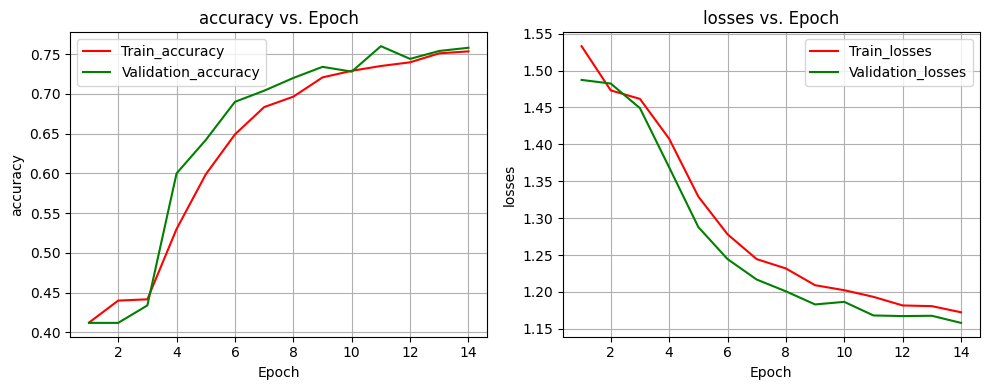

In [79]:
plot_findings(len(train_accuracies), [[train_accuracies, validation_accuracies], [train_losses, validation_losses]], "Epoch", isoptimal=True)

### Defining a function to process a single sentence from the test df

In [80]:
def preprocess_sentence(sentence, w2v_model, max_sentence_len):
    # Tokenize the sentence and convert the tokens to their corresponding indices in the word2vec model
    word_to_index = [w2v_model.key_to_index[word] if word in w2v_model.key_to_index else 3000000 for word in sentence.split()]
    
    # Save the actual length of the sentence
    actual_len = len(word_to_index)
    
    # Pad the tokenized sentence to max_sentence_len
    if len(word_to_index) < max_sentence_len:
        num_padding = max_sentence_len - len(word_to_index)
        word_to_index += [3000000] * num_padding

    # Convert the tokenized sentence to a tensor and add an extra dimension to make it a batch
    sentence_tensor = torch.tensor(word_to_index).unsqueeze(0).to(device)

    return sentence_tensor, torch.tensor([actual_len])

### Testing for a sentence in test.csv

In [81]:
sentence_index = 3
# Test model on one sentence
sentence = test_df.loc[sentence_index, 'text']
max_sentence_len = max(test_df['text'].apply(lambda x: len(x.split())))
preprocessed_input, sentence_len = preprocess_sentence(sentence,w2v,max_sentence_len)
output = model(preprocessed_input, sentence_len=sentence_len, mode=mode, _device=device)

# Get the predicted label
predicted_label = torch.argmax(output, dim=1)

# Convert the predicted label to its original string form
predicted_label_str = labels_dict_inverse[predicted_label.item()]

print(predicted_label_str)

OTHERS


In [82]:
print(test_df.loc[sentence_index])

label-coarse               OTHERS
label-fine                      7
text            What is an atom ?
Name: 3, dtype: object


## Here lies the optimization for most of the hyperparameters and how we defined them

### Different modes:

#### Mean Mode

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


 26%|██▌       | 13/50 [00:06<00:18,  2.02it/s]

Early stopping at epoch (14) due to no improvement in accuracy.
Time taken for the model to run finish: 6.45 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7960



 32%|███▏      | 16/50 [00:06<00:13,  2.45it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.52 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.7880



 32%|███▏      | 16/50 [00:06<00:13,  2.44it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.56 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.7760



 32%|███▏      | 16/50 [00:06<00:14,  2.41it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.65 seconds
Time taken to run finish the test: 0.05 seconds
Test Accuracy: 0.7820



 32%|███▏      | 16/50 [00:06<00:14,  2.41it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.64 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7820



 32%|███▏      | 16/50 [00:06<00:13,  2.48it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.46 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.7660



 32%|███▏      | 16/50 [00:06<00:13,  2.44it/s]


Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.56 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7780


 32%|███▏      | 16/50 [00:06<00:13,  2.47it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.47 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7900



 32%|███▏      | 16/50 [00:06<00:14,  2.41it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.64 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7860



 32%|███▏      | 16/50 [00:06<00:13,  2.47it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.48 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.7800


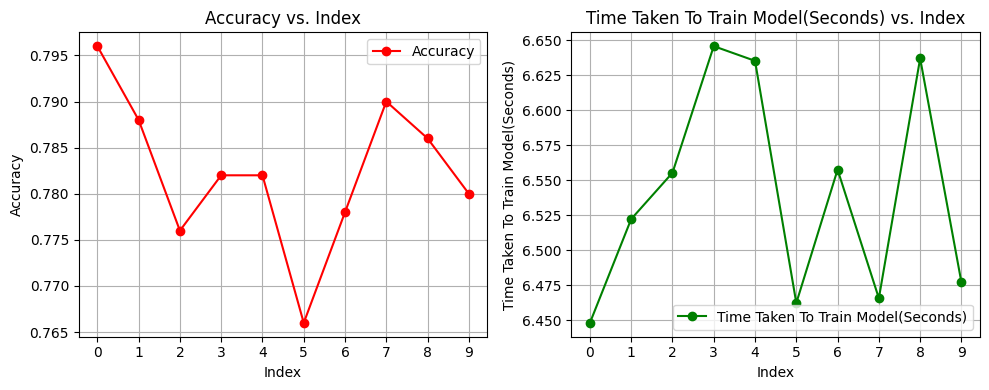

Best accuracy for All Mean Runs: 0, 0.796


In [15]:
batch_size = 128
hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
mean_run_index = [i for i in range(10)]

for run in mean_run_index:
    train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode= mode,
                                        device=device, epochs=epoch, random_initial_state=False, 
                                        learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(mean_run_index, [acc, tt], "Index")
print(f"Best accuracy for All Mean Runs: {mean_run_index[acc.index(max(acc))]}, {max(acc)}")

#### Max Mode

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


 32%|███▏      | 16/50 [00:02<00:06,  5.48it/s]


Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 2.92 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4400


 34%|███▍      | 17/50 [00:03<00:06,  5.48it/s]


Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 3.10 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4540


 40%|████      | 20/50 [00:03<00:05,  5.73it/s]


Early stopping at epoch (21) due to no improvement in accuracy.
Time taken for the model to run finish: 3.49 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4640


 36%|███▌      | 18/50 [00:03<00:05,  5.74it/s]


Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 3.14 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4360


 38%|███▊      | 19/50 [00:03<00:05,  5.66it/s]


Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 3.36 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4560


 38%|███▊      | 19/50 [00:03<00:05,  5.83it/s]


Early stopping at epoch (20) due to no improvement in accuracy.
Time taken for the model to run finish: 3.26 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4580


 62%|██████▏   | 31/50 [00:05<00:03,  5.87it/s]

Early stopping at epoch (32) due to no improvement in accuracy.
Time taken for the model to run finish: 5.28 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7180



 60%|██████    | 30/50 [00:05<00:03,  5.89it/s]


Early stopping at epoch (31) due to no improvement in accuracy.
Time taken for the model to run finish: 5.10 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.6000


 58%|█████▊    | 29/50 [00:04<00:03,  6.00it/s]


Early stopping at epoch (30) due to no improvement in accuracy.
Time taken for the model to run finish: 4.83 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.7320


 46%|████▌     | 23/50 [00:03<00:04,  5.93it/s]


Early stopping at epoch (24) due to no improvement in accuracy.
Time taken for the model to run finish: 3.88 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4400


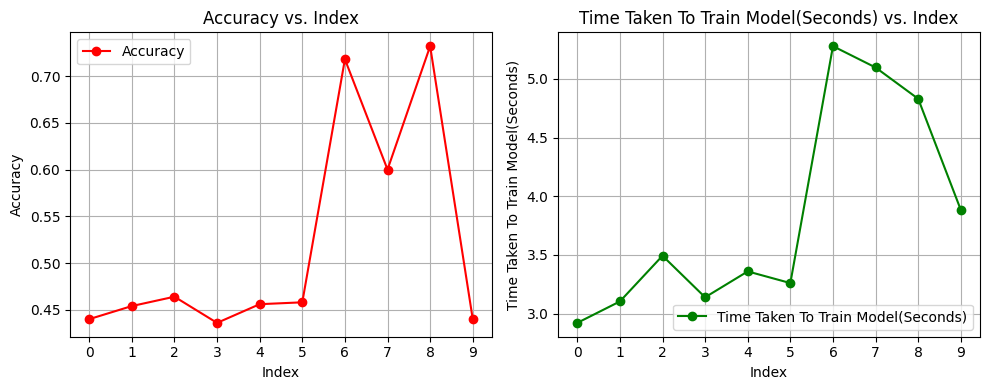

Best accuracy for All Max Size: 8, 0.732


In [16]:
batch_size = 128
hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "max"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
max_run_index = [i for i in range(10)]

for run in max_run_index:
    train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode= mode,
                                        device=device, epochs=epoch, random_initial_state=False, 
                                        learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(max_run_index, [acc, tt], "Index")
print(f"Best accuracy for All Max Size: {max_run_index[acc.index(max(acc))]}, {max(acc)}")

#### RNN Mode

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


  2%|▏         | 1/50 [00:00<00:22,  2.14it/s]

Epoch 1/50, Train Loss: 1.4874, Val Loss: 1.4920, Train Accuracy: 0.4309, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:20,  2.30it/s]

Epoch 2/50, Train Loss: 1.4765, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:20,  2.25it/s]

Epoch 3/50, Train Loss: 1.4762, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:19,  2.31it/s]

Epoch 4/50, Train Loss: 1.4761, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:18,  2.39it/s]

Epoch 5/50, Train Loss: 1.4721, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:18,  2.40it/s]

Epoch 6/50, Train Loss: 1.4771, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:02<00:17,  2.41it/s]

Epoch 7/50, Train Loss: 1.4776, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:17,  2.43it/s]

Epoch 8/50, Train Loss: 1.4778, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:03<00:16,  2.46it/s]

Epoch 9/50, Train Loss: 1.4735, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:16,  2.49it/s]

Epoch 10/50, Train Loss: 1.4752, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:04<00:15,  2.52it/s]

Epoch 11/50, Train Loss: 1.4769, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:04<00:15,  2.52it/s]

Epoch 12/50, Train Loss: 1.4775, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:05<00:14,  2.53it/s]

Epoch 13/50, Train Loss: 1.4750, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:05<00:14,  2.48it/s]

Epoch 14/50, Train Loss: 1.4785, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:06<00:14,  2.49it/s]

Epoch 15/50, Train Loss: 1.4780, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:06<00:13,  2.48it/s]

Epoch 16/50, Train Loss: 1.4782, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:06<00:13,  2.49it/s]

Epoch 17/50, Train Loss: 1.4738, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:07<00:12,  2.50it/s]

Epoch 18/50, Train Loss: 1.4775, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:07<00:12,  2.50it/s]

Epoch 19/50, Train Loss: 1.4753, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:08<00:12,  2.50it/s]

Epoch 20/50, Train Loss: 1.4786, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:08<00:11,  2.52it/s]

Epoch 21/50, Train Loss: 1.4769, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:08<00:11,  2.54it/s]

Epoch 22/50, Train Loss: 1.4779, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:09<00:10,  2.51it/s]

Epoch 23/50, Train Loss: 1.4762, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:09<00:10,  2.51it/s]

Epoch 24/50, Train Loss: 1.4756, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:10<00:10,  2.45it/s]

Epoch 25/50, Train Loss: 1.4780, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:10<00:09,  2.49it/s]

Epoch 26/50, Train Loss: 1.4805, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:10<00:09,  2.47it/s]

Epoch 27/50, Train Loss: 1.4787, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:11<00:09,  2.44it/s]

Epoch 28/50, Train Loss: 1.4765, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:11<00:08,  2.46it/s]

Epoch 29/50, Train Loss: 1.4761, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:12<00:08,  2.48it/s]

Epoch 30/50, Train Loss: 1.4744, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:12<00:07,  2.44it/s]

Epoch 31/50, Train Loss: 1.4731, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:13<00:07,  2.46it/s]

Epoch 32/50, Train Loss: 1.4760, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:13<00:06,  2.49it/s]

Epoch 33/50, Train Loss: 1.4769, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:13<00:06,  2.47it/s]

Epoch 34/50, Train Loss: 1.4767, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:14<00:06,  2.50it/s]

Epoch 35/50, Train Loss: 1.4745, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:14<00:05,  2.44it/s]

Epoch 36/50, Train Loss: 1.4761, Val Loss: 1.4938, Train Accuracy: 0.4390, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:15<00:05,  2.37it/s]

Epoch 37/50, Train Loss: 1.4727, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:15<00:05,  2.38it/s]

Epoch 38/50, Train Loss: 1.4794, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:15<00:04,  2.38it/s]

Epoch 39/50, Train Loss: 1.4764, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:16<00:04,  2.44it/s]

Epoch 40/50, Train Loss: 1.4799, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:16<00:03,  2.43it/s]

Epoch 41/50, Train Loss: 1.4784, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:17<00:03,  2.35it/s]

Epoch 42/50, Train Loss: 1.4762, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:17<00:03,  2.24it/s]

Epoch 43/50, Train Loss: 1.4779, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:18<00:02,  2.25it/s]

Epoch 44/50, Train Loss: 1.4778, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:18<00:02,  2.33it/s]

Epoch 45/50, Train Loss: 1.4723, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:18<00:01,  2.34it/s]

Epoch 46/50, Train Loss: 1.4772, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:19<00:01,  2.40it/s]

Epoch 47/50, Train Loss: 1.4788, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:19<00:00,  2.45it/s]

Epoch 48/50, Train Loss: 1.4784, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:20<00:00,  2.34it/s]

Epoch 49/50, Train Loss: 1.4765, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:20<00:00,  2.43it/s]

Epoch 50/50, Train Loss: 1.4764, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 20.58 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:24,  1.97it/s]

Epoch 1/50, Train Loss: 1.4874, Val Loss: 1.4920, Train Accuracy: 0.4225, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:22,  2.16it/s]

Epoch 2/50, Train Loss: 1.4759, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:20,  2.26it/s]

Epoch 3/50, Train Loss: 1.4753, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:19,  2.38it/s]

Epoch 4/50, Train Loss: 1.4750, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:18,  2.40it/s]

Epoch 5/50, Train Loss: 1.4745, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:17,  2.50it/s]

Epoch 6/50, Train Loss: 1.4775, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:02<00:16,  2.53it/s]

Epoch 7/50, Train Loss: 1.4768, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:16,  2.57it/s]

Epoch 8/50, Train Loss: 1.4763, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:03<00:15,  2.60it/s]

Epoch 9/50, Train Loss: 1.4746, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:15,  2.63it/s]

Epoch 10/50, Train Loss: 1.4763, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:04<00:14,  2.64it/s]

Epoch 11/50, Train Loss: 1.4769, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:04<00:14,  2.66it/s]

Epoch 12/50, Train Loss: 1.4756, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:05<00:14,  2.54it/s]

Epoch 13/50, Train Loss: 1.4773, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:05<00:15,  2.32it/s]

Epoch 14/50, Train Loss: 1.4799, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:06<00:15,  2.24it/s]

Epoch 15/50, Train Loss: 1.4741, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:06<00:15,  2.20it/s]

Epoch 16/50, Train Loss: 1.4769, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:07<00:14,  2.21it/s]

Epoch 17/50, Train Loss: 1.4738, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:07<00:14,  2.15it/s]

Epoch 18/50, Train Loss: 1.4750, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:08<00:14,  2.18it/s]

Epoch 19/50, Train Loss: 1.4754, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:08<00:13,  2.19it/s]

Epoch 20/50, Train Loss: 1.4758, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:08<00:13,  2.17it/s]

Epoch 21/50, Train Loss: 1.4751, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:09<00:13,  2.08it/s]

Epoch 22/50, Train Loss: 1.4779, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:10<00:13,  2.04it/s]

Epoch 23/50, Train Loss: 1.4752, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:10<00:12,  2.07it/s]

Epoch 24/50, Train Loss: 1.4772, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:10<00:12,  2.05it/s]

Epoch 25/50, Train Loss: 1.4761, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:11<00:11,  2.07it/s]

Epoch 26/50, Train Loss: 1.4737, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:11<00:11,  2.09it/s]

Epoch 27/50, Train Loss: 1.4742, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:12<00:10,  2.12it/s]

Epoch 28/50, Train Loss: 1.4775, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:12<00:09,  2.17it/s]

Epoch 29/50, Train Loss: 1.4766, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:13<00:09,  2.22it/s]

Epoch 30/50, Train Loss: 1.4722, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:13<00:08,  2.18it/s]

Epoch 31/50, Train Loss: 1.4739, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:14<00:08,  2.17it/s]

Epoch 32/50, Train Loss: 1.4742, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:14<00:07,  2.19it/s]

Epoch 33/50, Train Loss: 1.4763, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:15<00:07,  2.19it/s]

Epoch 34/50, Train Loss: 1.4788, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:15<00:06,  2.21it/s]

Epoch 35/50, Train Loss: 1.4767, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:15<00:06,  2.21it/s]

Epoch 36/50, Train Loss: 1.4762, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:16<00:05,  2.18it/s]

Epoch 37/50, Train Loss: 1.4761, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:16<00:05,  2.22it/s]

Epoch 38/50, Train Loss: 1.4789, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:17<00:04,  2.26it/s]

Epoch 39/50, Train Loss: 1.4767, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:17<00:04,  2.23it/s]

Epoch 40/50, Train Loss: 1.4787, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:18<00:04,  2.22it/s]

Epoch 41/50, Train Loss: 1.4774, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:18<00:03,  2.23it/s]

Epoch 42/50, Train Loss: 1.4776, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:19<00:03,  2.21it/s]

Epoch 43/50, Train Loss: 1.4771, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:19<00:02,  2.24it/s]

Epoch 44/50, Train Loss: 1.4770, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:20<00:02,  2.25it/s]

Epoch 45/50, Train Loss: 1.4772, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:20<00:01,  2.27it/s]

Epoch 46/50, Train Loss: 1.4765, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:20<00:01,  2.20it/s]

Epoch 47/50, Train Loss: 1.4790, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:21<00:00,  2.21it/s]

Epoch 48/50, Train Loss: 1.4762, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:21<00:00,  2.10it/s]

Epoch 49/50, Train Loss: 1.4746, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]

Epoch 50/50, Train Loss: 1.4750, Val Loss: 1.4930, Train Accuracy: 0.4388, Validation Accuracy: 0.4120
Time taken for the model to run finish: 22.36 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:22,  2.13it/s]

Epoch 1/50, Train Loss: 1.4860, Val Loss: 1.4920, Train Accuracy: 0.4340, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:20,  2.29it/s]

Epoch 2/50, Train Loss: 1.4749, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:19,  2.38it/s]

Epoch 3/50, Train Loss: 1.4754, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:19,  2.36it/s]

Epoch 4/50, Train Loss: 1.4776, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:18,  2.37it/s]

Epoch 5/50, Train Loss: 1.4751, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:18,  2.38it/s]

Epoch 6/50, Train Loss: 1.4772, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:02<00:17,  2.41it/s]

Epoch 7/50, Train Loss: 1.4763, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:17,  2.43it/s]

Epoch 8/50, Train Loss: 1.4755, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:03<00:16,  2.43it/s]

Epoch 9/50, Train Loss: 1.4767, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:16,  2.41it/s]

Epoch 10/50, Train Loss: 1.4744, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:04<00:16,  2.37it/s]

Epoch 11/50, Train Loss: 1.4748, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:05<00:16,  2.37it/s]

Epoch 12/50, Train Loss: 1.4778, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:05<00:15,  2.35it/s]

Epoch 13/50, Train Loss: 1.4787, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:05<00:15,  2.39it/s]

Epoch 14/50, Train Loss: 1.4727, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:06<00:14,  2.39it/s]

Epoch 15/50, Train Loss: 1.4775, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:06<00:14,  2.42it/s]

Epoch 16/50, Train Loss: 1.4730, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:07<00:13,  2.43it/s]

Epoch 17/50, Train Loss: 1.4731, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:07<00:13,  2.44it/s]

Epoch 18/50, Train Loss: 1.4718, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:07<00:12,  2.45it/s]

Epoch 19/50, Train Loss: 1.4726, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:08<00:12,  2.44it/s]

Epoch 20/50, Train Loss: 1.4775, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:08<00:12,  2.37it/s]

Epoch 21/50, Train Loss: 1.4752, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:09<00:11,  2.38it/s]

Epoch 22/50, Train Loss: 1.4768, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:09<00:11,  2.38it/s]

Epoch 23/50, Train Loss: 1.4784, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:10<00:10,  2.40it/s]

Epoch 24/50, Train Loss: 1.4750, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:10<00:10,  2.40it/s]

Epoch 25/50, Train Loss: 1.4775, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:10<00:10,  2.37it/s]

Epoch 26/50, Train Loss: 1.4743, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:11<00:09,  2.40it/s]

Epoch 27/50, Train Loss: 1.4761, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:11<00:09,  2.40it/s]

Epoch 28/50, Train Loss: 1.4764, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:12<00:08,  2.41it/s]

Epoch 29/50, Train Loss: 1.4751, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:12<00:08,  2.39it/s]

Epoch 30/50, Train Loss: 1.4762, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:12<00:07,  2.38it/s]

Epoch 31/50, Train Loss: 1.4744, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:13<00:07,  2.38it/s]

Epoch 32/50, Train Loss: 1.4786, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:13<00:07,  2.37it/s]

Epoch 33/50, Train Loss: 1.4795, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:14<00:06,  2.38it/s]

Epoch 34/50, Train Loss: 1.4756, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:14<00:06,  2.40it/s]

Epoch 35/50, Train Loss: 1.4759, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:15<00:05,  2.35it/s]

Epoch 36/50, Train Loss: 1.4748, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:15<00:05,  2.35it/s]

Epoch 37/50, Train Loss: 1.4744, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:15<00:05,  2.36it/s]

Epoch 38/50, Train Loss: 1.4771, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:16<00:04,  2.34it/s]

Epoch 39/50, Train Loss: 1.4753, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:16<00:04,  2.37it/s]

Epoch 40/50, Train Loss: 1.4749, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:17<00:03,  2.39it/s]

Epoch 41/50, Train Loss: 1.4765, Val Loss: 1.4932, Train Accuracy: 0.4362, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:17<00:03,  2.31it/s]

Epoch 42/50, Train Loss: 1.4792, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:18<00:03,  2.32it/s]

Epoch 43/50, Train Loss: 1.4718, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:18<00:02,  2.31it/s]

Epoch 44/50, Train Loss: 1.4761, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:18<00:02,  2.32it/s]

Epoch 45/50, Train Loss: 1.4755, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:19<00:01,  2.27it/s]

Epoch 46/50, Train Loss: 1.4766, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:19<00:01,  2.24it/s]

Epoch 47/50, Train Loss: 1.4747, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:20<00:00,  2.26it/s]

Epoch 48/50, Train Loss: 1.4745, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:20<00:00,  2.28it/s]

Epoch 49/50, Train Loss: 1.4795, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:21<00:00,  2.36it/s]

Epoch 50/50, Train Loss: 1.4754, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 21.16 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:23,  2.12it/s]

Epoch 1/50, Train Loss: 1.4877, Val Loss: 1.4920, Train Accuracy: 0.4267, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:21,  2.26it/s]

Epoch 2/50, Train Loss: 1.4786, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:20,  2.33it/s]

Epoch 3/50, Train Loss: 1.4738, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:19,  2.33it/s]

Epoch 4/50, Train Loss: 1.4754, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:19,  2.28it/s]

Epoch 5/50, Train Loss: 1.4754, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:18,  2.33it/s]

Epoch 6/50, Train Loss: 1.4714, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:03<00:18,  2.33it/s]

Epoch 7/50, Train Loss: 1.4769, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:17,  2.36it/s]

Epoch 8/50, Train Loss: 1.4755, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:03<00:17,  2.38it/s]

Epoch 9/50, Train Loss: 1.4745, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:16,  2.38it/s]

Epoch 10/50, Train Loss: 1.4750, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:04<00:16,  2.38it/s]

Epoch 11/50, Train Loss: 1.4758, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:05<00:16,  2.37it/s]

Epoch 12/50, Train Loss: 1.4738, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:05<00:15,  2.39it/s]

Epoch 13/50, Train Loss: 1.4752, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:05<00:14,  2.41it/s]

Epoch 14/50, Train Loss: 1.4789, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:06<00:15,  2.31it/s]

Epoch 15/50, Train Loss: 1.4756, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:06<00:14,  2.34it/s]

Epoch 16/50, Train Loss: 1.4738, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:07<00:13,  2.36it/s]

Epoch 17/50, Train Loss: 1.4779, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:07<00:13,  2.35it/s]

Epoch 18/50, Train Loss: 1.4757, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:08<00:13,  2.36it/s]

Epoch 19/50, Train Loss: 1.4808, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:08<00:12,  2.36it/s]

Epoch 20/50, Train Loss: 1.4796, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:08<00:12,  2.38it/s]

Epoch 21/50, Train Loss: 1.4765, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:09<00:11,  2.36it/s]

Epoch 22/50, Train Loss: 1.4775, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:09<00:11,  2.35it/s]

Epoch 23/50, Train Loss: 1.4772, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:10<00:11,  2.34it/s]

Epoch 24/50, Train Loss: 1.4742, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:10<00:10,  2.31it/s]

Epoch 25/50, Train Loss: 1.4744, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:11<00:10,  2.32it/s]

Epoch 26/50, Train Loss: 1.4727, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:11<00:09,  2.33it/s]

Epoch 27/50, Train Loss: 1.4749, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:11<00:09,  2.33it/s]

Epoch 28/50, Train Loss: 1.4754, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:12<00:09,  2.30it/s]

Epoch 29/50, Train Loss: 1.4759, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:12<00:08,  2.28it/s]

Epoch 30/50, Train Loss: 1.4751, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:13<00:08,  2.27it/s]

Epoch 31/50, Train Loss: 1.4741, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:13<00:07,  2.30it/s]

Epoch 32/50, Train Loss: 1.4751, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:14<00:07,  2.29it/s]

Epoch 33/50, Train Loss: 1.4763, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:14<00:06,  2.32it/s]

Epoch 34/50, Train Loss: 1.4732, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:15<00:06,  2.28it/s]

Epoch 35/50, Train Loss: 1.4785, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:15<00:06,  2.29it/s]

Epoch 36/50, Train Loss: 1.4749, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:15<00:05,  2.31it/s]

Epoch 37/50, Train Loss: 1.4761, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:16<00:05,  2.32it/s]

Epoch 38/50, Train Loss: 1.4756, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:16<00:04,  2.33it/s]

Epoch 39/50, Train Loss: 1.4771, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:17<00:04,  2.33it/s]

Epoch 40/50, Train Loss: 1.4784, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:17<00:03,  2.31it/s]

Epoch 41/50, Train Loss: 1.4746, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:18<00:03,  2.28it/s]

Epoch 42/50, Train Loss: 1.4750, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:18<00:03,  2.26it/s]

Epoch 43/50, Train Loss: 1.4750, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:18<00:02,  2.28it/s]

Epoch 44/50, Train Loss: 1.4791, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:19<00:02,  2.29it/s]

Epoch 45/50, Train Loss: 1.4752, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:19<00:01,  2.28it/s]

Epoch 46/50, Train Loss: 1.4765, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:20<00:01,  2.29it/s]

Epoch 47/50, Train Loss: 1.4774, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:20<00:00,  2.29it/s]

Epoch 48/50, Train Loss: 1.4768, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:21<00:00,  2.02it/s]

Epoch 49/50, Train Loss: 1.4734, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:21<00:00,  2.29it/s]

Epoch 50/50, Train Loss: 1.4766, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 21.82 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:29,  1.64it/s]

Epoch 1/50, Train Loss: 1.4815, Val Loss: 1.4920, Train Accuracy: 0.4237, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:01<00:27,  1.77it/s]

Epoch 2/50, Train Loss: 1.4765, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:25,  1.87it/s]

Epoch 3/50, Train Loss: 1.4756, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:02<00:28,  1.62it/s]

Epoch 4/50, Train Loss: 1.4787, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:24,  1.81it/s]

Epoch 5/50, Train Loss: 1.4799, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:03<00:29,  1.50it/s]

Epoch 6/50, Train Loss: 1.4760, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:04<00:26,  1.65it/s]

Epoch 7/50, Train Loss: 1.4767, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:04<00:24,  1.70it/s]

Epoch 8/50, Train Loss: 1.4753, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:05<00:25,  1.59it/s]

Epoch 9/50, Train Loss: 1.4757, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:06<00:24,  1.63it/s]

Epoch 10/50, Train Loss: 1.4757, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:06<00:23,  1.68it/s]

Epoch 11/50, Train Loss: 1.4778, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:07<00:22,  1.68it/s]

Epoch 12/50, Train Loss: 1.4745, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:07<00:21,  1.72it/s]

Epoch 13/50, Train Loss: 1.4798, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:08<00:23,  1.54it/s]

Epoch 14/50, Train Loss: 1.4775, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:08<00:20,  1.70it/s]

Epoch 15/50, Train Loss: 1.4775, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:09<00:19,  1.70it/s]

Epoch 16/50, Train Loss: 1.4779, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:10<00:17,  1.84it/s]

Epoch 17/50, Train Loss: 1.4733, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:10<00:16,  1.93it/s]

Epoch 18/50, Train Loss: 1.4743, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:10<00:15,  2.05it/s]

Epoch 19/50, Train Loss: 1.4734, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:11<00:14,  2.09it/s]

Epoch 20/50, Train Loss: 1.4730, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:11<00:14,  2.05it/s]

Epoch 21/50, Train Loss: 1.4767, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:12<00:13,  2.11it/s]

Epoch 22/50, Train Loss: 1.4762, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:12<00:14,  1.92it/s]

Epoch 23/50, Train Loss: 1.4753, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:13<00:12,  2.03it/s]

Epoch 24/50, Train Loss: 1.4751, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:13<00:11,  2.11it/s]

Epoch 25/50, Train Loss: 1.4766, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:14<00:11,  2.15it/s]

Epoch 26/50, Train Loss: 1.4774, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:14<00:10,  2.17it/s]

Epoch 27/50, Train Loss: 1.4752, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:15<00:10,  2.17it/s]

Epoch 28/50, Train Loss: 1.4781, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:15<00:09,  2.16it/s]

Epoch 29/50, Train Loss: 1.4752, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:16<00:09,  2.14it/s]

Epoch 30/50, Train Loss: 1.4783, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:16<00:08,  2.17it/s]

Epoch 31/50, Train Loss: 1.4758, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:16<00:08,  2.19it/s]

Epoch 32/50, Train Loss: 1.4770, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:17<00:07,  2.23it/s]

Epoch 33/50, Train Loss: 1.4736, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:17<00:07,  2.20it/s]

Epoch 34/50, Train Loss: 1.4761, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:18<00:06,  2.24it/s]

Epoch 35/50, Train Loss: 1.4752, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:18<00:06,  2.25it/s]

Epoch 36/50, Train Loss: 1.4741, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:19<00:05,  2.23it/s]

Epoch 37/50, Train Loss: 1.4744, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:19<00:05,  2.26it/s]

Epoch 38/50, Train Loss: 1.4763, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:20<00:04,  2.28it/s]

Epoch 39/50, Train Loss: 1.4776, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:20<00:04,  2.29it/s]

Epoch 40/50, Train Loss: 1.4787, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:20<00:03,  2.31it/s]

Epoch 41/50, Train Loss: 1.4763, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:21<00:03,  2.27it/s]

Epoch 42/50, Train Loss: 1.4762, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:21<00:03,  2.26it/s]

Epoch 43/50, Train Loss: 1.4738, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:22<00:02,  2.28it/s]

Epoch 44/50, Train Loss: 1.4775, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:22<00:02,  2.30it/s]

Epoch 45/50, Train Loss: 1.4768, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:23<00:01,  2.28it/s]

Epoch 46/50, Train Loss: 1.4755, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:23<00:01,  2.27it/s]

Epoch 47/50, Train Loss: 1.4770, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:24<00:00,  2.26it/s]

Epoch 48/50, Train Loss: 1.4775, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:24<00:00,  1.97it/s]

Epoch 49/50, Train Loss: 1.4746, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:25<00:00,  1.99it/s]

Epoch 50/50, Train Loss: 1.4754, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 25.16 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:22,  2.16it/s]

Epoch 1/50, Train Loss: 1.4880, Val Loss: 1.4920, Train Accuracy: 0.4241, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:21,  2.27it/s]

Epoch 2/50, Train Loss: 1.4757, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:20,  2.29it/s]

Epoch 3/50, Train Loss: 1.4743, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:20,  2.29it/s]

Epoch 4/50, Train Loss: 1.4750, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:19,  2.30it/s]

Epoch 5/50, Train Loss: 1.4721, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:19,  2.29it/s]

Epoch 6/50, Train Loss: 1.4779, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:03<00:18,  2.31it/s]

Epoch 7/50, Train Loss: 1.4754, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:18,  2.32it/s]

Epoch 8/50, Train Loss: 1.4772, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:03<00:17,  2.30it/s]

Epoch 9/50, Train Loss: 1.4760, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:17,  2.28it/s]

Epoch 10/50, Train Loss: 1.4790, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:04<00:17,  2.28it/s]

Epoch 11/50, Train Loss: 1.4755, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:05<00:16,  2.27it/s]

Epoch 12/50, Train Loss: 1.4755, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:05<00:16,  2.24it/s]

Epoch 13/50, Train Loss: 1.4761, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:06<00:15,  2.26it/s]

Epoch 14/50, Train Loss: 1.4753, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:06<00:15,  2.27it/s]

Epoch 15/50, Train Loss: 1.4751, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:07<00:14,  2.28it/s]

Epoch 16/50, Train Loss: 1.4760, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:07<00:14,  2.24it/s]

Epoch 17/50, Train Loss: 1.4748, Val Loss: 1.4938, Train Accuracy: 0.4380, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:07<00:14,  2.22it/s]

Epoch 18/50, Train Loss: 1.4785, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:08<00:13,  2.25it/s]

Epoch 19/50, Train Loss: 1.4808, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:08<00:13,  2.26it/s]

Epoch 20/50, Train Loss: 1.4742, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:09<00:12,  2.28it/s]

Epoch 21/50, Train Loss: 1.4768, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:09<00:12,  2.31it/s]

Epoch 22/50, Train Loss: 1.4780, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:10<00:11,  2.29it/s]

Epoch 23/50, Train Loss: 1.4743, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:10<00:11,  2.29it/s]

Epoch 24/50, Train Loss: 1.4779, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:10<00:10,  2.30it/s]

Epoch 25/50, Train Loss: 1.4773, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:11<00:10,  2.31it/s]

Epoch 26/50, Train Loss: 1.4776, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:11<00:09,  2.32it/s]

Epoch 27/50, Train Loss: 1.4783, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:12<00:09,  2.32it/s]

Epoch 28/50, Train Loss: 1.4757, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:12<00:09,  2.27it/s]

Epoch 29/50, Train Loss: 1.4764, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:13<00:08,  2.28it/s]

Epoch 30/50, Train Loss: 1.4759, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:13<00:08,  2.28it/s]

Epoch 31/50, Train Loss: 1.4733, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:14<00:07,  2.28it/s]

Epoch 32/50, Train Loss: 1.4785, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:14<00:07,  2.28it/s]

Epoch 33/50, Train Loss: 1.4749, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:14<00:07,  2.26it/s]

Epoch 34/50, Train Loss: 1.4753, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:15<00:06,  2.27it/s]

Epoch 35/50, Train Loss: 1.4742, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:15<00:06,  2.27it/s]

Epoch 36/50, Train Loss: 1.4730, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:16<00:05,  2.27it/s]

Epoch 37/50, Train Loss: 1.4768, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:16<00:05,  2.28it/s]

Epoch 38/50, Train Loss: 1.4753, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:17<00:04,  2.29it/s]

Epoch 39/50, Train Loss: 1.4790, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:17<00:04,  2.28it/s]

Epoch 40/50, Train Loss: 1.4792, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:17<00:03,  2.28it/s]

Epoch 41/50, Train Loss: 1.4737, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:18<00:03,  2.27it/s]

Epoch 42/50, Train Loss: 1.4741, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:18<00:03,  2.26it/s]

Epoch 43/50, Train Loss: 1.4761, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:19<00:02,  2.26it/s]

Epoch 44/50, Train Loss: 1.4767, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:19<00:02,  2.27it/s]

Epoch 45/50, Train Loss: 1.4721, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:20<00:01,  2.28it/s]

Epoch 46/50, Train Loss: 1.4808, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:20<00:01,  2.25it/s]

Epoch 47/50, Train Loss: 1.4739, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:21<00:00,  2.27it/s]

Epoch 48/50, Train Loss: 1.4762, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:21<00:00,  2.28it/s]

Epoch 49/50, Train Loss: 1.4724, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:21<00:00,  2.28it/s]

Epoch 50/50, Train Loss: 1.4742, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 21.95 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:24,  2.04it/s]

Epoch 1/50, Train Loss: 1.4871, Val Loss: 1.4920, Train Accuracy: 0.4233, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:22,  2.15it/s]

Epoch 2/50, Train Loss: 1.4744, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:21,  2.22it/s]

Epoch 3/50, Train Loss: 1.4788, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:20,  2.23it/s]

Epoch 4/50, Train Loss: 1.4756, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:20,  2.25it/s]

Epoch 5/50, Train Loss: 1.4773, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:19,  2.26it/s]

Epoch 6/50, Train Loss: 1.4751, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:03<00:19,  2.26it/s]

Epoch 7/50, Train Loss: 1.4791, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:18,  2.28it/s]

Epoch 8/50, Train Loss: 1.4767, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:04<00:18,  2.25it/s]

Epoch 9/50, Train Loss: 1.4772, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:17,  2.25it/s]

Epoch 10/50, Train Loss: 1.4753, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:04<00:17,  2.26it/s]

Epoch 11/50, Train Loss: 1.4780, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:05<00:16,  2.27it/s]

Epoch 12/50, Train Loss: 1.4747, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:05<00:16,  2.26it/s]

Epoch 13/50, Train Loss: 1.4727, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:06<00:15,  2.27it/s]

Epoch 14/50, Train Loss: 1.4719, Val Loss: 1.4909, Train Accuracy: 0.4396, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:06<00:15,  2.28it/s]

Epoch 15/50, Train Loss: 1.4758, Val Loss: 1.4920, Train Accuracy: 0.4364, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:07<00:14,  2.29it/s]

Epoch 16/50, Train Loss: 1.4745, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:07<00:14,  2.29it/s]

Epoch 17/50, Train Loss: 1.4776, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:07<00:14,  2.28it/s]

Epoch 18/50, Train Loss: 1.4738, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:08<00:13,  2.28it/s]

Epoch 19/50, Train Loss: 1.4763, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:08<00:13,  2.29it/s]

Epoch 20/50, Train Loss: 1.4760, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:09<00:12,  2.28it/s]

Epoch 21/50, Train Loss: 1.4783, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:09<00:12,  2.29it/s]

Epoch 22/50, Train Loss: 1.4802, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:10<00:11,  2.27it/s]

Epoch 23/50, Train Loss: 1.4743, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:10<00:11,  2.27it/s]

Epoch 24/50, Train Loss: 1.4782, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:11<00:11,  2.27it/s]

Epoch 25/50, Train Loss: 1.4770, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:11<00:10,  2.28it/s]

Epoch 26/50, Train Loss: 1.4742, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:12<00:11,  2.01it/s]

Epoch 27/50, Train Loss: 1.4778, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:12<00:11,  1.91it/s]

Epoch 28/50, Train Loss: 1.4759, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:13<00:10,  1.95it/s]

Epoch 29/50, Train Loss: 1.4733, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:13<00:09,  2.03it/s]

Epoch 30/50, Train Loss: 1.4750, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:14<00:09,  2.07it/s]

Epoch 31/50, Train Loss: 1.4736, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:14<00:08,  2.01it/s]

Epoch 32/50, Train Loss: 1.4770, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:15<00:08,  1.91it/s]

Epoch 33/50, Train Loss: 1.4817, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:15<00:07,  2.00it/s]

Epoch 34/50, Train Loss: 1.4762, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:16<00:08,  1.76it/s]

Epoch 35/50, Train Loss: 1.4742, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:17<00:08,  1.66it/s]

Epoch 36/50, Train Loss: 1.4756, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:17<00:07,  1.73it/s]

Epoch 37/50, Train Loss: 1.4780, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:18<00:07,  1.70it/s]

Epoch 38/50, Train Loss: 1.4804, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:18<00:06,  1.76it/s]

Epoch 39/50, Train Loss: 1.4751, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:19<00:05,  1.85it/s]

Epoch 40/50, Train Loss: 1.4775, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:19<00:05,  1.68it/s]

Epoch 41/50, Train Loss: 1.4778, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:20<00:04,  1.65it/s]

Epoch 42/50, Train Loss: 1.4769, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:21<00:04,  1.63it/s]

Epoch 43/50, Train Loss: 1.4738, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:21<00:03,  1.67it/s]

Epoch 44/50, Train Loss: 1.4782, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:22<00:02,  1.81it/s]

Epoch 45/50, Train Loss: 1.4748, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:22<00:02,  1.79it/s]

Epoch 46/50, Train Loss: 1.4781, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:23<00:01,  1.86it/s]

Epoch 47/50, Train Loss: 1.4766, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:23<00:01,  1.95it/s]

Epoch 48/50, Train Loss: 1.4755, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:24<00:00,  1.98it/s]

Epoch 49/50, Train Loss: 1.4755, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:24<00:00,  2.03it/s]

Epoch 50/50, Train Loss: 1.4753, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 24.64 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:24,  2.00it/s]

Epoch 1/50, Train Loss: 1.4919, Val Loss: 1.4920, Train Accuracy: 0.4233, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:01<00:24,  1.94it/s]

Epoch 2/50, Train Loss: 1.4786, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:29,  1.61it/s]

Epoch 3/50, Train Loss: 1.4804, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:02<00:26,  1.76it/s]

Epoch 4/50, Train Loss: 1.4748, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:27,  1.61it/s]

Epoch 5/50, Train Loss: 1.4753, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:03<00:24,  1.77it/s]

Epoch 6/50, Train Loss: 1.4760, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:03<00:23,  1.81it/s]

Epoch 7/50, Train Loss: 1.4766, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:04<00:21,  1.94it/s]

Epoch 8/50, Train Loss: 1.4754, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:04<00:20,  2.04it/s]

Epoch 9/50, Train Loss: 1.4766, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:05<00:18,  2.12it/s]

Epoch 10/50, Train Loss: 1.4747, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:05<00:18,  2.16it/s]

Epoch 11/50, Train Loss: 1.4735, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:06<00:17,  2.16it/s]

Epoch 12/50, Train Loss: 1.4737, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:06<00:16,  2.20it/s]

Epoch 13/50, Train Loss: 1.4781, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:07<00:16,  2.22it/s]

Epoch 14/50, Train Loss: 1.4773, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:07<00:15,  2.22it/s]

Epoch 15/50, Train Loss: 1.4754, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:07<00:15,  2.22it/s]

Epoch 16/50, Train Loss: 1.4738, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:08<00:14,  2.22it/s]

Epoch 17/50, Train Loss: 1.4745, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:08<00:14,  2.22it/s]

Epoch 18/50, Train Loss: 1.4757, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:09<00:14,  2.20it/s]

Epoch 19/50, Train Loss: 1.4788, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:09<00:13,  2.21it/s]

Epoch 20/50, Train Loss: 1.4779, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:10<00:12,  2.23it/s]

Epoch 21/50, Train Loss: 1.4773, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:10<00:12,  2.26it/s]

Epoch 22/50, Train Loss: 1.4771, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:11<00:11,  2.28it/s]

Epoch 23/50, Train Loss: 1.4729, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:11<00:11,  2.25it/s]

Epoch 24/50, Train Loss: 1.4755, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:11<00:10,  2.27it/s]

Epoch 25/50, Train Loss: 1.4741, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:12<00:10,  2.29it/s]

Epoch 26/50, Train Loss: 1.4774, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:12<00:10,  2.29it/s]

Epoch 27/50, Train Loss: 1.4764, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:13<00:09,  2.30it/s]

Epoch 28/50, Train Loss: 1.4775, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:13<00:09,  2.29it/s]

Epoch 29/50, Train Loss: 1.4747, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:14<00:08,  2.31it/s]

Epoch 30/50, Train Loss: 1.4797, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:14<00:08,  2.32it/s]

Epoch 31/50, Train Loss: 1.4768, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:14<00:07,  2.32it/s]

Epoch 32/50, Train Loss: 1.4788, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:15<00:07,  2.31it/s]

Epoch 33/50, Train Loss: 1.4789, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:15<00:06,  2.31it/s]

Epoch 34/50, Train Loss: 1.4744, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:16<00:06,  2.30it/s]

Epoch 35/50, Train Loss: 1.4787, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:16<00:06,  2.28it/s]

Epoch 36/50, Train Loss: 1.4769, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:17<00:05,  2.22it/s]

Epoch 37/50, Train Loss: 1.4801, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:17<00:05,  2.23it/s]

Epoch 38/50, Train Loss: 1.4778, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:18<00:04,  2.22it/s]

Epoch 39/50, Train Loss: 1.4777, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:18<00:04,  2.20it/s]

Epoch 40/50, Train Loss: 1.4744, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:19<00:04,  2.21it/s]

Epoch 41/50, Train Loss: 1.4734, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:19<00:03,  2.21it/s]

Epoch 42/50, Train Loss: 1.4731, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:19<00:03,  2.17it/s]

Epoch 43/50, Train Loss: 1.4768, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:20<00:02,  2.20it/s]

Epoch 44/50, Train Loss: 1.4739, Val Loss: 1.4924, Train Accuracy: 0.4356, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:20<00:02,  2.22it/s]

Epoch 45/50, Train Loss: 1.4778, Val Loss: 1.4940, Train Accuracy: 0.4376, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:21<00:01,  2.23it/s]

Epoch 46/50, Train Loss: 1.4773, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:21<00:01,  2.22it/s]

Epoch 47/50, Train Loss: 1.4747, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:22<00:00,  2.25it/s]

Epoch 48/50, Train Loss: 1.4762, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:22<00:00,  2.25it/s]

Epoch 49/50, Train Loss: 1.4771, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]

Epoch 50/50, Train Loss: 1.4782, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 23.06 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:23,  2.09it/s]

Epoch 1/50, Train Loss: 1.4868, Val Loss: 1.4920, Train Accuracy: 0.4299, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:22,  2.14it/s]

Epoch 2/50, Train Loss: 1.4752, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:21,  2.19it/s]

Epoch 3/50, Train Loss: 1.4766, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:20,  2.23it/s]

Epoch 4/50, Train Loss: 1.4740, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:20,  2.25it/s]

Epoch 5/50, Train Loss: 1.4785, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:19,  2.26it/s]

Epoch 6/50, Train Loss: 1.4747, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:03<00:18,  2.27it/s]

Epoch 7/50, Train Loss: 1.4780, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:20,  2.01it/s]

Epoch 8/50, Train Loss: 1.4734, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:04<00:19,  2.07it/s]

Epoch 9/50, Train Loss: 1.4763, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:21,  1.89it/s]

Epoch 10/50, Train Loss: 1.4744, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:05<00:21,  1.84it/s]

Epoch 11/50, Train Loss: 1.4778, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:05<00:20,  1.85it/s]

Epoch 12/50, Train Loss: 1.4741, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:06<00:19,  1.91it/s]

Epoch 13/50, Train Loss: 1.4765, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:06<00:18,  1.95it/s]

Epoch 14/50, Train Loss: 1.4731, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:07<00:17,  1.99it/s]

Epoch 15/50, Train Loss: 1.4786, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:08<00:19,  1.77it/s]

Epoch 16/50, Train Loss: 1.4755, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:08<00:19,  1.67it/s]

Epoch 17/50, Train Loss: 1.4729, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:09<00:19,  1.64it/s]

Epoch 18/50, Train Loss: 1.4792, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:10<00:19,  1.62it/s]

Epoch 19/50, Train Loss: 1.4751, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:10<00:17,  1.69it/s]

Epoch 20/50, Train Loss: 1.4750, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:11<00:17,  1.68it/s]

Epoch 21/50, Train Loss: 1.4765, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:11<00:15,  1.81it/s]

Epoch 22/50, Train Loss: 1.4772, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:12<00:14,  1.92it/s]

Epoch 23/50, Train Loss: 1.4762, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:12<00:13,  2.00it/s]

Epoch 24/50, Train Loss: 1.4756, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:12<00:12,  2.07it/s]

Epoch 25/50, Train Loss: 1.4783, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:13<00:11,  2.11it/s]

Epoch 26/50, Train Loss: 1.4767, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:13<00:10,  2.15it/s]

Epoch 27/50, Train Loss: 1.4787, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:14<00:10,  2.18it/s]

Epoch 28/50, Train Loss: 1.4778, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:14<00:09,  2.20it/s]

Epoch 29/50, Train Loss: 1.4768, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:15<00:09,  2.22it/s]

Epoch 30/50, Train Loss: 1.4736, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:15<00:08,  2.22it/s]

Epoch 31/50, Train Loss: 1.4756, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:16<00:08,  2.23it/s]

Epoch 32/50, Train Loss: 1.4738, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:16<00:07,  2.23it/s]

Epoch 33/50, Train Loss: 1.4728, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:17<00:07,  2.23it/s]

Epoch 34/50, Train Loss: 1.4767, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:17<00:06,  2.24it/s]

Epoch 35/50, Train Loss: 1.4760, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:17<00:06,  2.22it/s]

Epoch 36/50, Train Loss: 1.4758, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:18<00:05,  2.20it/s]

Epoch 37/50, Train Loss: 1.4774, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:18<00:05,  2.21it/s]

Epoch 38/50, Train Loss: 1.4748, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:19<00:04,  2.22it/s]

Epoch 39/50, Train Loss: 1.4761, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:19<00:04,  2.24it/s]

Epoch 40/50, Train Loss: 1.4801, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:20<00:04,  2.24it/s]

Epoch 41/50, Train Loss: 1.4754, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:20<00:03,  2.24it/s]

Epoch 42/50, Train Loss: 1.4746, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:21<00:03,  2.24it/s]

Epoch 43/50, Train Loss: 1.4779, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:21<00:02,  2.24it/s]

Epoch 44/50, Train Loss: 1.4746, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:21<00:02,  2.25it/s]

Epoch 45/50, Train Loss: 1.4752, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:22<00:01,  2.25it/s]

Epoch 46/50, Train Loss: 1.4768, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:22<00:01,  2.24it/s]

Epoch 47/50, Train Loss: 1.4747, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:23<00:00,  2.24it/s]

Epoch 48/50, Train Loss: 1.4745, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:23<00:00,  2.25it/s]

Epoch 49/50, Train Loss: 1.4771, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:24<00:00,  2.07it/s]

Epoch 50/50, Train Loss: 1.4780, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 24.17 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060



  2%|▏         | 1/50 [00:00<00:23,  2.05it/s]

Epoch 1/50, Train Loss: 1.4884, Val Loss: 1.4920, Train Accuracy: 0.4227, Validation Accuracy: 0.4120


  4%|▍         | 2/50 [00:00<00:22,  2.17it/s]

Epoch 2/50, Train Loss: 1.4789, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  6%|▌         | 3/50 [00:01<00:21,  2.21it/s]

Epoch 3/50, Train Loss: 1.4736, Val Loss: 1.4952, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


  8%|▊         | 4/50 [00:01<00:20,  2.24it/s]

Epoch 4/50, Train Loss: 1.4759, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 10%|█         | 5/50 [00:02<00:20,  2.25it/s]

Epoch 5/50, Train Loss: 1.4754, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 12%|█▏        | 6/50 [00:02<00:19,  2.23it/s]

Epoch 6/50, Train Loss: 1.4761, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 14%|█▍        | 7/50 [00:03<00:19,  2.25it/s]

Epoch 7/50, Train Loss: 1.4757, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 16%|█▌        | 8/50 [00:03<00:18,  2.22it/s]

Epoch 8/50, Train Loss: 1.4772, Val Loss: 1.4936, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 18%|█▊        | 9/50 [00:04<00:18,  2.23it/s]

Epoch 9/50, Train Loss: 1.4729, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 20%|██        | 10/50 [00:04<00:17,  2.24it/s]

Epoch 10/50, Train Loss: 1.4781, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 22%|██▏       | 11/50 [00:04<00:17,  2.26it/s]

Epoch 11/50, Train Loss: 1.4760, Val Loss: 1.4948, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 24%|██▍       | 12/50 [00:05<00:16,  2.26it/s]

Epoch 12/50, Train Loss: 1.4772, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 26%|██▌       | 13/50 [00:05<00:16,  2.23it/s]

Epoch 13/50, Train Loss: 1.4723, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 28%|██▊       | 14/50 [00:06<00:16,  2.24it/s]

Epoch 14/50, Train Loss: 1.4780, Val Loss: 1.4910, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 30%|███       | 15/50 [00:06<00:15,  2.24it/s]

Epoch 15/50, Train Loss: 1.4724, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 32%|███▏      | 16/50 [00:07<00:15,  2.24it/s]

Epoch 16/50, Train Loss: 1.4743, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 34%|███▍      | 17/50 [00:07<00:14,  2.23it/s]

Epoch 17/50, Train Loss: 1.4729, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 36%|███▌      | 18/50 [00:08<00:14,  2.23it/s]

Epoch 18/50, Train Loss: 1.4758, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 38%|███▊      | 19/50 [00:08<00:13,  2.25it/s]

Epoch 19/50, Train Loss: 1.4744, Val Loss: 1.4908, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 40%|████      | 20/50 [00:08<00:13,  2.25it/s]

Epoch 20/50, Train Loss: 1.4767, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 42%|████▏     | 21/50 [00:09<00:12,  2.24it/s]

Epoch 21/50, Train Loss: 1.4755, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 44%|████▍     | 22/50 [00:09<00:12,  2.23it/s]

Epoch 22/50, Train Loss: 1.4774, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 46%|████▌     | 23/50 [00:10<00:11,  2.26it/s]

Epoch 23/50, Train Loss: 1.4761, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 48%|████▊     | 24/50 [00:10<00:11,  2.28it/s]

Epoch 24/50, Train Loss: 1.4753, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 50%|█████     | 25/50 [00:11<00:11,  2.24it/s]

Epoch 25/50, Train Loss: 1.4744, Val Loss: 1.4918, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 52%|█████▏    | 26/50 [00:11<00:10,  2.20it/s]

Epoch 26/50, Train Loss: 1.4770, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 54%|█████▍    | 27/50 [00:12<00:10,  2.19it/s]

Epoch 27/50, Train Loss: 1.4764, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 56%|█████▌    | 28/50 [00:12<00:10,  2.19it/s]

Epoch 28/50, Train Loss: 1.4749, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 58%|█████▊    | 29/50 [00:13<00:09,  2.20it/s]

Epoch 29/50, Train Loss: 1.4765, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 60%|██████    | 30/50 [00:13<00:09,  2.21it/s]

Epoch 30/50, Train Loss: 1.4746, Val Loss: 1.4906, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 62%|██████▏   | 31/50 [00:13<00:08,  2.23it/s]

Epoch 31/50, Train Loss: 1.4759, Val Loss: 1.4920, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 64%|██████▍   | 32/50 [00:14<00:07,  2.25it/s]

Epoch 32/50, Train Loss: 1.4766, Val Loss: 1.4942, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 66%|██████▌   | 33/50 [00:14<00:07,  2.28it/s]

Epoch 33/50, Train Loss: 1.4800, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 68%|██████▊   | 34/50 [00:15<00:07,  2.27it/s]

Epoch 34/50, Train Loss: 1.4773, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 70%|███████   | 35/50 [00:15<00:06,  2.28it/s]

Epoch 35/50, Train Loss: 1.4779, Val Loss: 1.4926, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 72%|███████▏  | 36/50 [00:16<00:06,  2.29it/s]

Epoch 36/50, Train Loss: 1.4770, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 74%|███████▍  | 37/50 [00:16<00:05,  2.29it/s]

Epoch 37/50, Train Loss: 1.4762, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 76%|███████▌  | 38/50 [00:16<00:05,  2.28it/s]

Epoch 38/50, Train Loss: 1.4768, Val Loss: 1.4916, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 78%|███████▊  | 39/50 [00:17<00:04,  2.29it/s]

Epoch 39/50, Train Loss: 1.4760, Val Loss: 1.4938, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 80%|████████  | 40/50 [00:17<00:04,  2.29it/s]

Epoch 40/50, Train Loss: 1.4753, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 82%|████████▏ | 41/50 [00:18<00:03,  2.29it/s]

Epoch 41/50, Train Loss: 1.4756, Val Loss: 1.4932, Train Accuracy: 0.4358, Validation Accuracy: 0.4120


 84%|████████▍ | 42/50 [00:18<00:03,  2.28it/s]

Epoch 42/50, Train Loss: 1.4746, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 86%|████████▌ | 43/50 [00:19<00:03,  2.27it/s]

Epoch 43/50, Train Loss: 1.4732, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 88%|████████▊ | 44/50 [00:19<00:02,  2.26it/s]

Epoch 44/50, Train Loss: 1.4753, Val Loss: 1.4924, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 90%|█████████ | 45/50 [00:20<00:02,  2.24it/s]

Epoch 45/50, Train Loss: 1.4748, Val Loss: 1.4940, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 92%|█████████▏| 46/50 [00:20<00:01,  2.22it/s]

Epoch 46/50, Train Loss: 1.4770, Val Loss: 1.4922, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 94%|█████████▍| 47/50 [00:20<00:01,  2.22it/s]

Epoch 47/50, Train Loss: 1.4776, Val Loss: 1.4928, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 96%|█████████▌| 48/50 [00:21<00:00,  2.21it/s]

Epoch 48/50, Train Loss: 1.4760, Val Loss: 1.4934, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


 98%|█████████▊| 49/50 [00:21<00:00,  2.20it/s]

Epoch 49/50, Train Loss: 1.4781, Val Loss: 1.4932, Train Accuracy: 0.4400, Validation Accuracy: 0.4120


100%|██████████| 50/50 [00:22<00:00,  2.24it/s]

Epoch 50/50, Train Loss: 1.4750, Val Loss: 1.4930, Train Accuracy: 0.4400, Validation Accuracy: 0.4120
Time taken for the model to run finish: 22.35 seconds
Time taken to run finish the test: 0.01 seconds
Test Accuracy: 0.4060


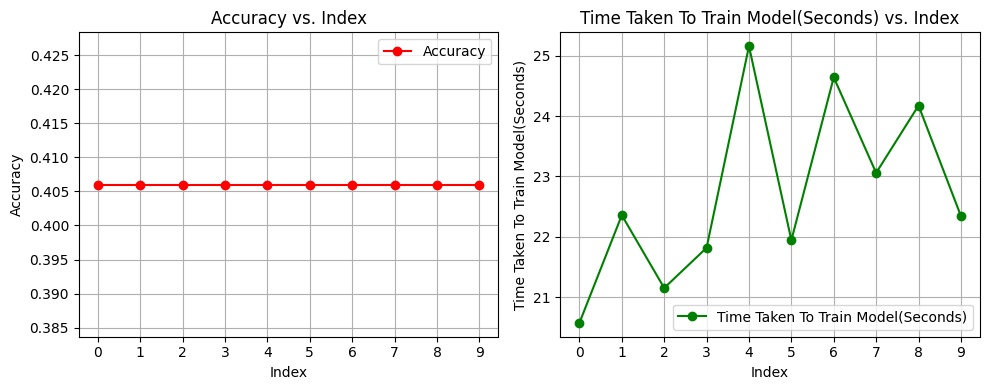

Best accuracy for All RNN Runs: 0, 0.406


In [26]:
batch_size = 128
hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "rnn"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
rnn_run_index = [i for i in range(10)]

for run in rnn_run_index:
    train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode= mode,
                                        device=device, epochs=epoch, random_initial_state=False, 
                                        learning_rate=learning_rate, early_stopper=early_stopper, debug=True)
    test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(rnn_run_index, [acc, tt], "Index")
print(f"Best accuracy for All RNN Runs: {rnn_run_index[acc.index(max(acc))]}, {max(acc)}")

### Best score for Batch Size:

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


 18%|█▊        | 9/50 [00:08<00:40,  1.02it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 8.86 seconds
Time taken to run finish the test: 0.06 seconds
Test Accuracy: 0.7740



 18%|█▊        | 9/50 [00:05<00:26,  1.52it/s]

Early stopping at epoch (10) due to no improvement in accuracy.
Time taken for the model to run finish: 5.93 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7860



 32%|███▏      | 16/50 [00:06<00:13,  2.43it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.59 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7860



 36%|███▌      | 18/50 [00:06<00:11,  2.70it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 6.67 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.7880



 56%|█████▌    | 28/50 [00:09<00:07,  2.96it/s]

Early stopping at epoch (29) due to no improvement in accuracy.
Time taken for the model to run finish: 9.47 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.7780



  6%|▌         | 3/50 [00:01<00:17,  2.70it/s]

Early stopping at epoch (4) due to no improvement in accuracy.
Time taken for the model to run finish: 1.11 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.4060


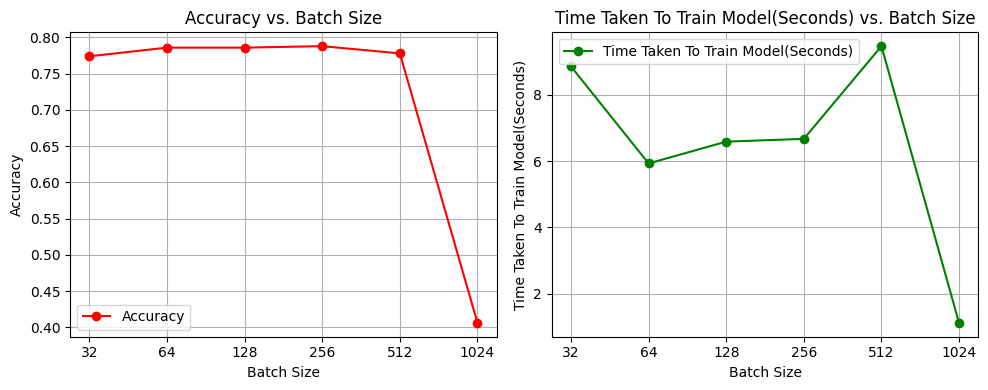

Best accuracy for Batch Size: 256, 0.788


In [86]:
# batch_size = 32
hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
batch_size = [32, 64, 128, 256, 512, 1024]
for BS in batch_size:
    train_data_loader, validation_data_loader = get_training_data(BS, w2v, train_df, validation_df)
    test_data_loader = get_test_data(BS, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode= mode,
                                        device=device, epochs=epoch, random_initial_state=False, 
                                        learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(batch_size, [acc, tt], "Batch Size")
print(f"Best accuracy for Batch Size: {batch_size[acc.index(max(acc))]}, {max(acc)}")

### Best score for Hidden Dimension:

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


 74%|███████▍  | 37/50 [00:15<00:05,  2.39it/s]

Early stopping at epoch (38) due to no improvement in accuracy.
Time taken for the model to run finish: 15.49 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7780



 58%|█████▊    | 29/50 [00:12<00:08,  2.42it/s]

Early stopping at epoch (30) due to no improvement in accuracy.
Time taken for the model to run finish: 12.01 seconds
Time taken to run finish the test: 0.05 seconds
Test Accuracy: 0.7740



 40%|████      | 20/50 [00:08<00:12,  2.39it/s]

Early stopping at epoch (21) due to no improvement in accuracy.
Time taken for the model to run finish: 8.37 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7880



 40%|████      | 20/50 [00:08<00:12,  2.34it/s]

Early stopping at epoch (21) due to no improvement in accuracy.
Time taken for the model to run finish: 8.56 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7660



 32%|███▏      | 16/50 [00:07<00:15,  2.27it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 7.06 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7700



 32%|███▏      | 16/50 [00:06<00:14,  2.31it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.94 seconds
Time taken to run finish the test: 0.04 seconds
Test Accuracy: 0.7780



 26%|██▌       | 13/50 [00:07<00:20,  1.84it/s]

Early stopping at epoch (14) due to no improvement in accuracy.
Time taken for the model to run finish: 7.06 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7840


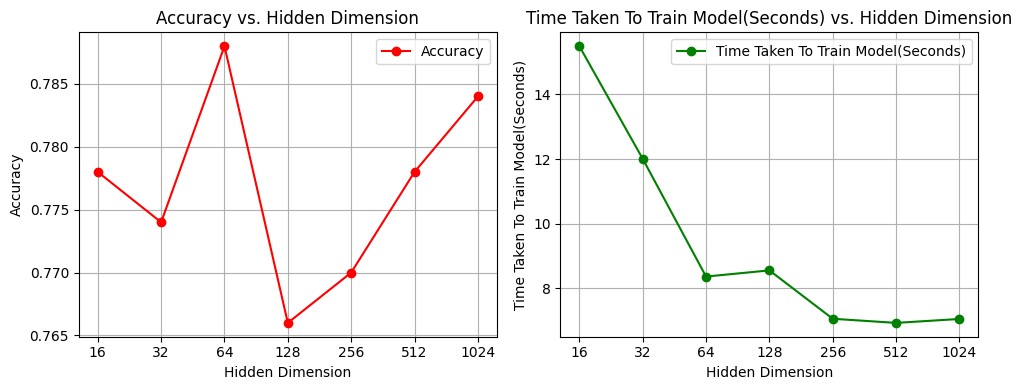

Best accuracy for Hidden Dimension: 64, 0.788


In [87]:
batch_size = 128
# hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
hidden_dim = [16, 32, 64, 128, 256, 512, 1024]
for HD in hidden_dim:
    train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, HD, num_labels, pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode= mode,
                                        device=device, epochs=epoch, random_initial_state=False, 
                                        learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(hidden_dim, [acc, tt], "Hidden Dimension")
print(f"Best accuracy for Hidden Dimension: {hidden_dim[acc.index(max(acc))]}, {max(acc)}")

### Best score for Learning Rate:

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Time taken for the model to run finish: 19.24 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7040


 32%|███▏      | 16/50 [00:06<00:13,  2.50it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.39 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.7880



 36%|███▌      | 18/50 [00:07<00:13,  2.45it/s]

Early stopping at epoch (19) due to no improvement in accuracy.
Time taken for the model to run finish: 7.35 seconds
Time taken to run finish the test: 0.05 seconds
Test Accuracy: 0.8120



100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Time taken for the model to run finish: 18.67 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.1880


100%|██████████| 50/50 [00:19<00:00,  2.63it/s]


Time taken for the model to run finish: 19.03 seconds
Time taken to run finish the test: 0.02 seconds
Test Accuracy: 0.4060


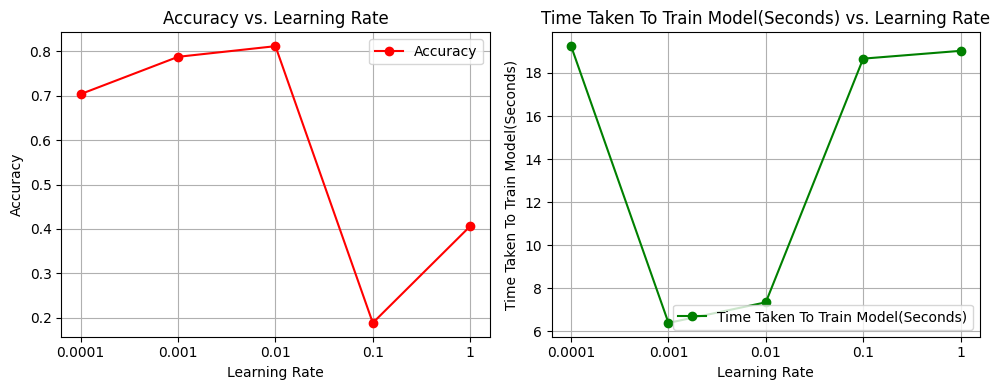

Best accuracy for Learning Rate: 0.01, 0.812


In [88]:
batch_size = 128
hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
# learning_rate = 0.001
dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
learning_rate = [0.0001, 0.001, 0.01, 0.1,1]
for lr in learning_rate:
    train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=dropout_prob)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode= mode,
                                        device=device, epochs=epoch, random_initial_state=False, 
                                        learning_rate=lr, early_stopper=early_stopper, debug=False)
    test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(learning_rate, [acc, tt], "Learning Rate")
print(f"Best accuracy for Learning Rate: {learning_rate[acc.index(max(acc))]}, {max(acc)}")

### Best score for Dropout Probability:

$ GPU Activated $
['OTHERS', 1, 4, 5, 2]
{'OTHERS': 0, 1: 1, 4: 2, 5: 3, 2: 4}
Length of num_labels:  5


 32%|███▏      | 16/50 [00:06<00:13,  2.47it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.49 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7900



 34%|███▍      | 17/50 [00:06<00:12,  2.54it/s]

Early stopping at epoch (18) due to no improvement in accuracy.
Time taken for the model to run finish: 6.69 seconds
Time taken to run finish the test: 0.05 seconds
Test Accuracy: 0.7800



 32%|███▏      | 16/50 [00:06<00:14,  2.35it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.80 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7840



 32%|███▏      | 16/50 [00:06<00:14,  2.39it/s]

Early stopping at epoch (17) due to no improvement in accuracy.
Time taken for the model to run finish: 6.71 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7780



 28%|██▊       | 14/50 [00:06<00:16,  2.24it/s]

Early stopping at epoch (15) due to no improvement in accuracy.
Time taken for the model to run finish: 6.26 seconds
Time taken to run finish the test: 0.03 seconds
Test Accuracy: 0.7720


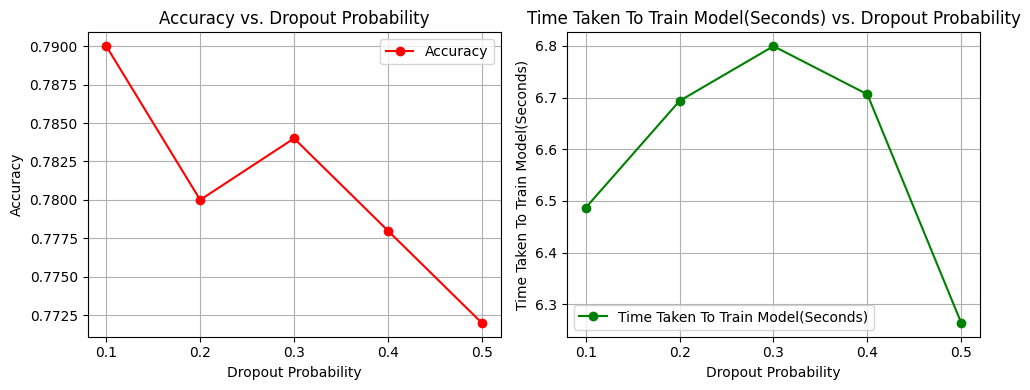

Best accuracy for Dropout Probability: 0.1, 0.79


In [89]:
batch_size = 128
hidden_dim = 512
embedding_dim = w2v.vector_size
early_stopper = EarlyStopper(patience=3)
device = get_device()
epoch = 50
learning_rate = 0.001
# dropout_prob = 0.2
mode = "mean"

# Getting list of labels
labels_list = train_df['label-coarse'].value_counts().index.tolist()
print(labels_list)
labels_dict = {label: i for i, label in enumerate(labels_list)}
labels_dict_inverse = {i: label for i, label in enumerate(labels_list)}
print(labels_dict)
num_labels = len(labels_list)
print("Length of num_labels: ", num_labels)

acc, tt = [], []
dropout_prob = [0.1, 0.2, 0.3, 0.4, 0.5]
for dp in dropout_prob:
    train_data_loader, validation_data_loader = get_training_data(batch_size, w2v, train_df, validation_df)
    test_data_loader = get_test_data(batch_size, w2v, random_seed=random_seed)
    model = get_model(embedding_dim, hidden_dim, num_labels, pretrained_embeddings, dropout_prob=dp)
    early_stopper = EarlyStopper(patience=3)

    _, _, _, _, time_taken = train_model(model, train_data_loader, validation_data_loader, mode= mode,
                                        device=device, epochs=epoch, random_initial_state=False, 
                                        learning_rate=learning_rate, early_stopper=early_stopper, debug=False)
    test_accuracy = test_model(model=model, test_data_loader=test_data_loader, mode=mode, device=device)
    acc.append(test_accuracy)
    tt.append(time_taken)

plot_findings(dropout_prob, [acc, tt], "Dropout Probability")
print(f"Best accuracy for Dropout Probability: {dropout_prob[acc.index(max(acc))]}, {max(acc)}")